In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn as sk

# Cargar el archivo CSV en un DataFrame
file_path = './Data/avocado.csv'
avocado = pd.read_csv(file_path)
avocado.rename(columns={'4046': 'Small Volume', '4225': 'Large Volume', '4770': 'XLarge Volume'}, inplace=True)
avocado.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,Small Volume,Large Volume,XLarge Volume,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


## Actividades de Análisis

### 1. **Análisis de Series Temporales**
**Resumen:** El análisis de series temporales permite identificar patrones, tendencias y estacionalidades en los precios y volúmenes de ventas de aguacates a lo largo del tiempo.

1. **Descomposición de Series Temporales de Precios:** 
   - **Uso de Datos:** Usa la columna `AveragePrice` y `Date`.
   - **Esperado:** Utiliza la función `seasonal_decompose` de la librería `statsmodels` para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido. 
     - Convierte `Date` a tipo datetime usando `pd.to_datetime()`.
     - Agrupa los datos por `Date` y calcula el promedio de `AveragePrice` utilizando `groupby()` si es necesario.
     - Visualiza los componentes descompuestos usando `matplotlib` para cada uno de ellos.

Media de precio mensual de aguacates:  1.405978409775878


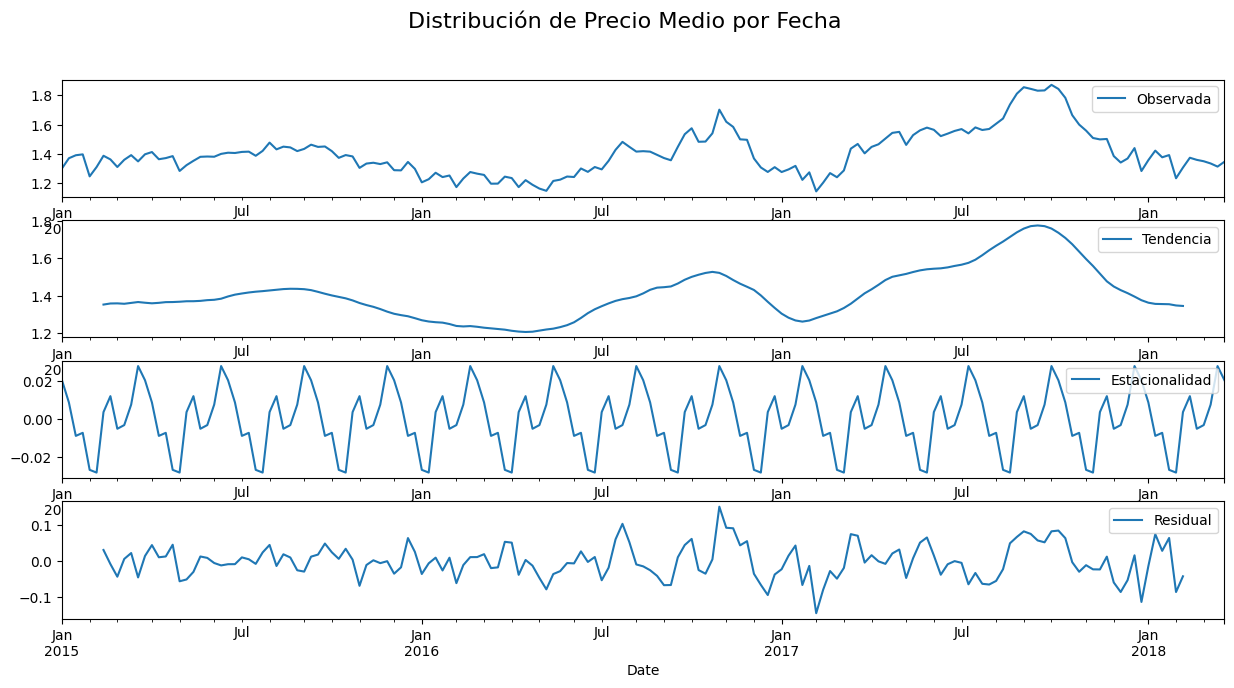

In [2]:
# Formatear fecha en DateTime
avocado["Date"] = pd.to_datetime(avocado["Date"])

# Agrupa los datos por `Date` y calcula el promedio de `AveragePrice` utilizando `groupby()` si es necesario.

monthly_mean = avocado.groupby(avocado.Date)["AveragePrice"].mean()

# Visualiza los componentes descompuestos usando `matplotlib` para cada uno de ellos.

global_mean = avocado[["AveragePrice"]].mean().iloc[0]
print("Media de precio mensual de aguacates: ",global_mean)

decompose = sm.tsa.seasonal_decompose(monthly_mean, model="additive", period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 7))

fig.suptitle('Distribución de Precio Medio por Fecha', fontsize=16)
decompose.observed.plot(ax=axes[0], legend=True, label="Observada")
decompose.trend.plot(ax=axes[1 ], legend=True, label="Tendencia")
decompose.seasonal.plot(ax=axes[2], legend=True, label="Estacionalidad")
decompose.resid.plot(ax=axes[3], legend=True, label="Residual")

plt.show()

2. **Análisis de Estacionalidad por Región:** 
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Date` y `Total Volume`.
   - **Esperado:** Utiliza gráficos de líneas para visualizar cómo varían los precios de aguacates por región a lo largo de diferentes estaciones del año.
     - Agrupa los datos por `region` y `Date` utilizando `groupby()`.
     - Calcula el promedio de `AveragePrice` para cada región.
     - Representa gráficamente las tendencias utilizando `plt.plot()` de `matplotlib`.

In [3]:
avocado["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [4]:
print("Separamos los datos por tipo de region, ya que estos se solapan y alteran los análisis")

avocado['region_type'] = 'local_region'
avocado.loc[avocado.region == 'TotalUS', 'region_type'] = 'wide_region'
group = ['West', 'California', 'SouthCentral', 'Northeast', 'Southeast', 'GreatLakes', 'Midsouth', 'Plains']
avocado.loc[avocado.region.isin(group), 'region_type'] = 'middle_region'

avocado.groupby('region_type')['region'].count()

avo_local = avocado.loc[avocado.region_type == 'local_region']
avo_middle = avocado.loc[avocado.region_type == 'middle_region']
avo_wide = avocado.loc[avocado.region_type == 'wide_region']

avo_local.groupby('region')['Unnamed: 0',].count()

Separamos los datos por tipo de region, ya que estos se solapan y alteran los análisis


,Unnamed: 0
region,
Albany,338
Atlanta,338
BaltimoreWashington,338
Boise,338
Boston,338
BuffaloRochester,338
Charlotte,338
Chicago,338
CincinnatiDayton,338


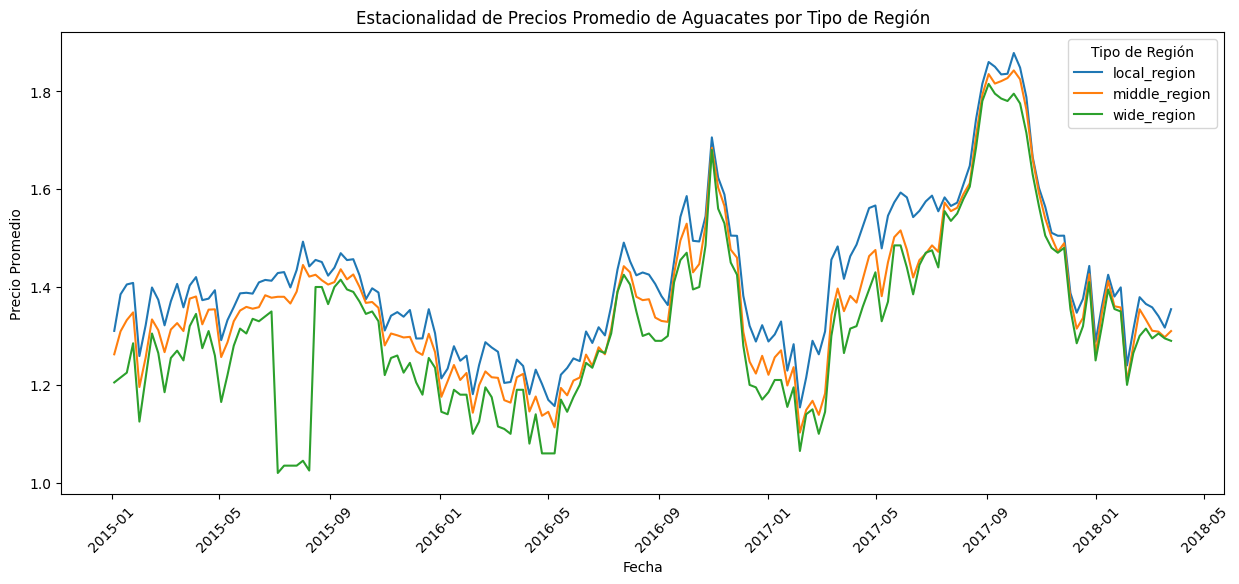

In [5]:
# Agrupa por tipo de región y mes, y calcula la media de AveragePrice
date_mean = avocado.groupby(['region_type', 'Date'])['AveragePrice'].mean().reset_index()

# Grafica la estacionalidad por tipo de región
plt.figure(figsize=(15, 6))

# Hace un gráfico de líneas para cada tipo de región
for region_type in date_mean['region_type'].unique():
    # Filtra los datos por cada tipo de región
    data = date_mean[date_mean['region_type'] == region_type]
    
    # Grafica la tendencia de precios promedio
    plt.plot(data['Date'], data['AveragePrice'], label=region_type)

plt.title('Estacionalidad de Precios Promedio de Aguacates por Tipo de Región')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.legend(title='Tipo de Región')
plt.xticks(rotation=45)
plt.show()


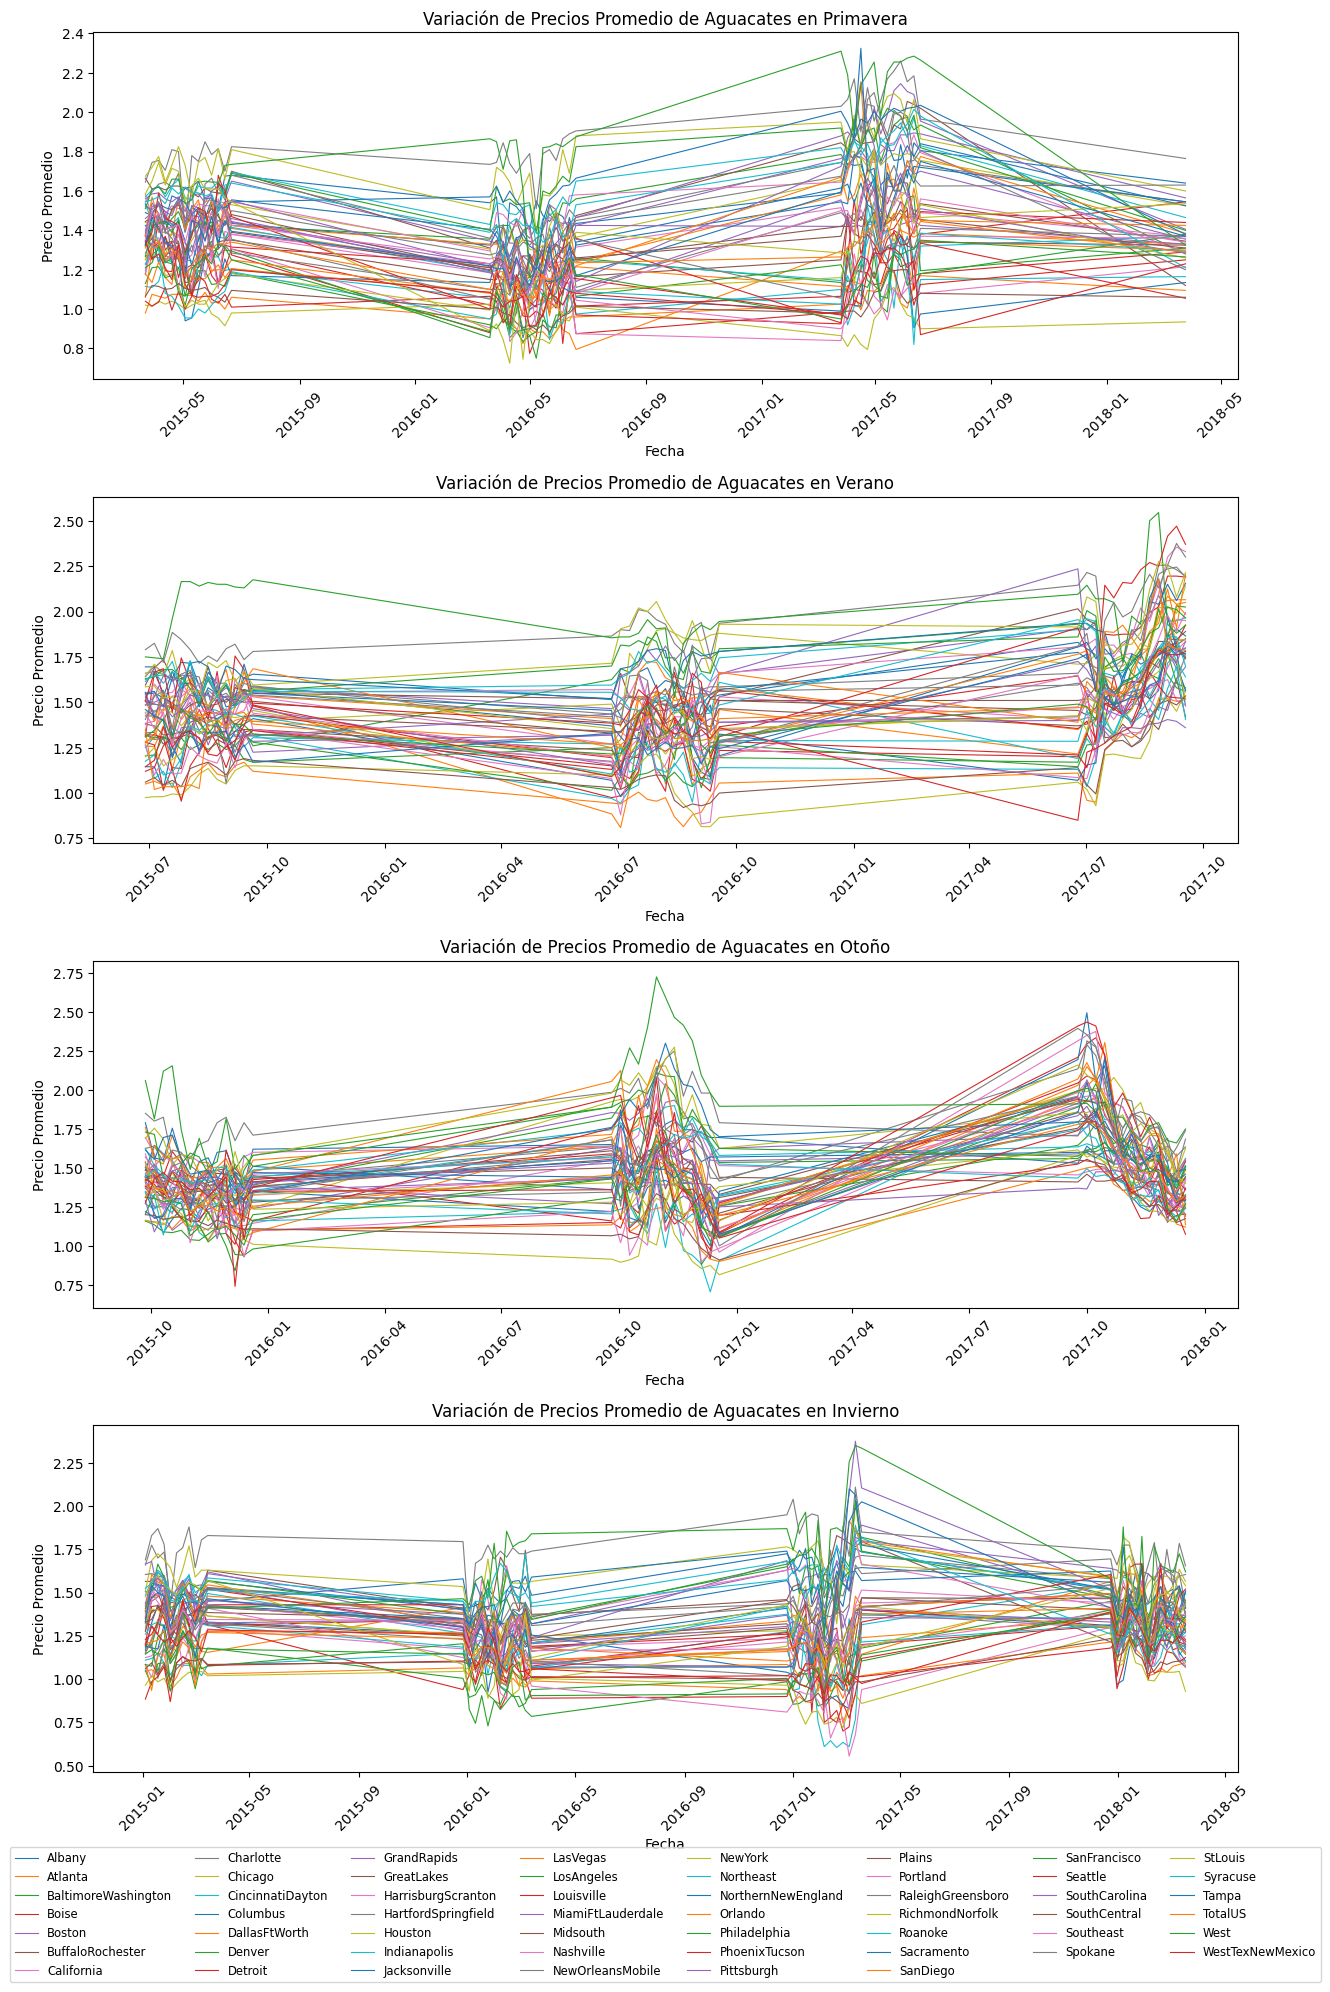

In [6]:
# La función determina la estación de acuerdo a la fecha
def get_season(date):
    month = date.month
    day = date.day
    for season, ((start_month, start_day), (end_month, end_day)) in seasons.items():
        if (month == start_month and day >= start_day) or (month == end_month and day <= end_day) or \
           (start_month < month < end_month) or \
           (start_month > end_month and (month > start_month or month < end_month)):
            return season
    return None

# Calculamos el promedio de `AveragePrice` y el volumen total `Total Volume` por región y fecha
avocado_grouped = avocado.groupby(['region', 'Date']).agg({'AveragePrice': 'mean', 'Total Volume': 'sum'}).reset_index()

# Definimos los límites de las estaciones
seasons = {
    'Primavera': ((3, 20), (6, 21)),
    'Verano': ((6, 21), (9, 22)),
    'Otoño': ((9, 22), (12, 21)),
    'Invierno': ((12, 21), (3, 20))
}

# Añadimos una columna 'Season' en el DataFrame agrupado
avocado_grouped['Season'] = avocado_grouped['Date'].apply(get_season)

# Graficamos los precios promedio por región en cada estación
plt.figure(figsize=(14, 20))

for i, season in enumerate(seasons.keys(), 1):
    season_data = avocado_grouped[avocado_grouped['Season'] == season]
    plt.subplot(4, 1, i)
    for region, data in season_data.groupby('region'):
        plt.plot(data['Date'], data['AveragePrice'], label=region, linewidth=0.8)
    plt.title(f"Variación de Precios Promedio de Aguacates en {season}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio Promedio")
    plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize='small', ncol=8)

plt.tight_layout()
plt.show()

3. **Comparación de Precios Promedio Mensuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Date`.
   - **Esperado:** Calcula y compara los precios promedio mensuales.
     - Agrupa los datos por mes usando `pd.Grouper` con `freq='M'`.
     - Calcula el promedio de `AveragePrice` para cada mes con `mean()`.
     - Visualiza los resultados con un gráfico de líneas usando `plt.plot()`.

4. **Tendencia de Ventas a lo Largo del Tiempo:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `Date`.
   - **Esperado:** Analiza cómo varía el volumen total de ventas a lo largo del tiempo.
     - Agrupa los datos por `Date` y suma el `Total Volume` usando `groupby()`.
     - Visualiza los resultados usando un gráfico de líneas con `plt.plot()` para mostrar la tendencia.

5. **Análisis de Cambios en Precios Anuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `year`.
   - **Esperado:** Observa las diferencias anuales en los precios promedio.
     - Agrupa los datos por `year` utilizando `groupby()`.
     - Calcula el promedio de `AveragePrice` para cada año.
     - Representa los resultados en un gráfico de barras usando `plt.bar()` que compare los precios de cada año.


### 2. **Gráficos para Visualización de Datos**
**Resumen:** La visualización de datos es clave para identificar patrones y relaciones entre diferentes variables. Los gráficos apropiados pueden proporcionar información valiosa sobre el comportamiento de los precios y volúmenes de ventas.

1. **Gráfico de Violín de Volumen de Ventas por Región:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `region`.
   - **Esperado:** Visualiza la distribución de ventas en diferentes regiones.
     - Utiliza la función `violinplot` de `seaborn` para crear gráficos de violín.
     - Configura los ejes para mostrar la relación entre `Total Volume` y `region`.
     - Añade etiquetas y títulos usando `plt.title()` y `plt.xlabel()` para facilitar la interpretación.

2. **Boxplot Comparativo de Precios entre Años:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `year`.
   - **Esperado:** Genera boxplots para comparar la distribución de precios.
     - Utiliza `boxplot` de `seaborn` para crear boxplots que comparen `AveragePrice` entre diferentes años.
     - Asegúrate de que cada boxplot represente un año diferente.
     - Incluye etiquetas y títulos descriptivos usando `plt.title()`.

Text(0, 0.5, 'Precio Promedio')

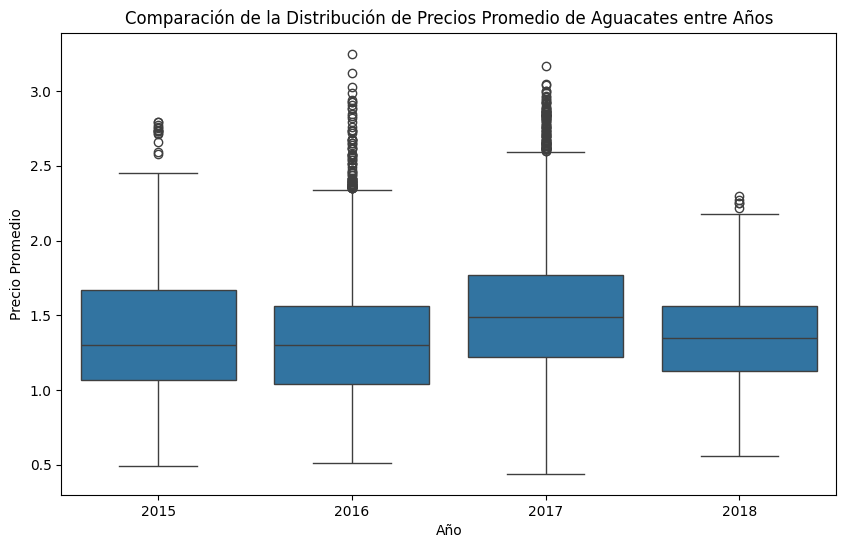

In [7]:
#codigo
# Indico el tamaño del grafico
plt.figure(figsize=(10, 6))

# Boxplot de precios promedio por año
sns.boxplot(x='year', y='AveragePrice', data=avocado)

plt.title('Comparación de la Distribución de Precios Promedio de Aguacates entre Años')
plt.xlabel('Año')
plt.ylabel('Precio Promedio')

3. **Histograma de Volumen Total de Ventas:**
   - **Uso de Datos:** Usa la columna `Total Volume`.
   - **Esperado:** Crea un histograma para mostrar la distribución del volumen total de ventas.
     - Utiliza `hist()` de `matplotlib` para crear el histograma.
     - Ajusta el número de bins para una visualización clara usando el parámetro `bins`.
     - Añade etiquetas y un título que describa lo que se muestra.

4. **Gráfico de Barras de Ventas por Tipo de Bolsa:**
   - **Uso de Datos:** Utiliza las columnas `Total Bags`, `Small Bags`, `Large Bags` y `XLarge Bags`.
   - **Esperado:** Compara las ventas de diferentes tipos de bolsas.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `sum()`.
     - Crea un gráfico de barras con `plt.bar()` para mostrar las diferencias en ventas.
     - Asegúrate de incluir etiquetas para cada tipo de bolsa.

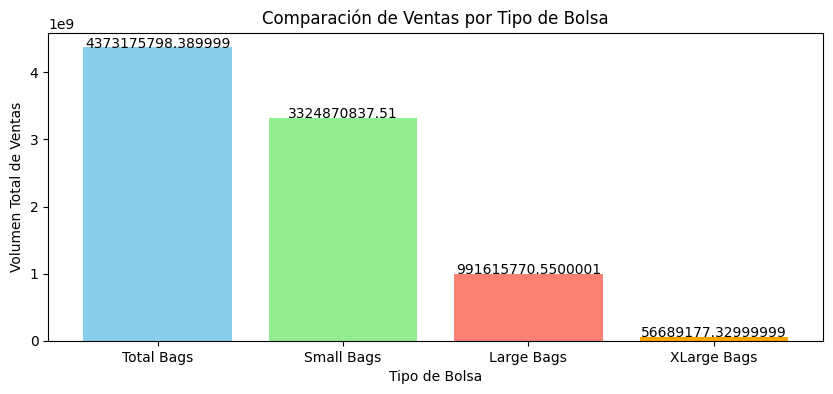

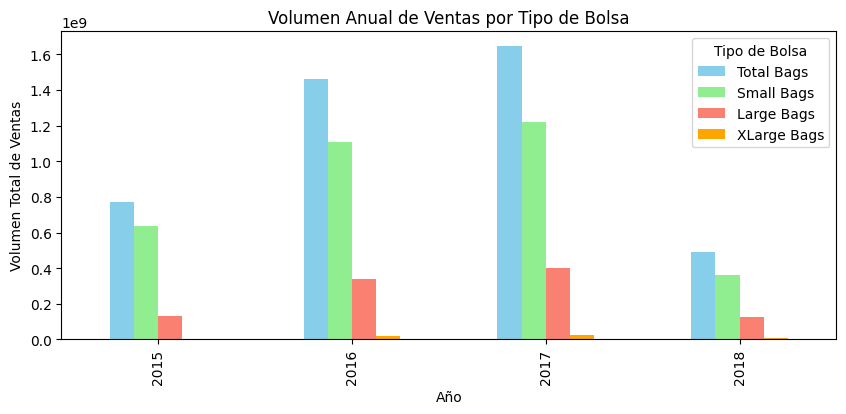

In [8]:

def sales_monthly_average_bag(df):
    # Calcular la suma total de ventas por tipo de bolsa
    total_bags = df['Total Bags'].sum()
    small_bags = df['Small Bags'].sum()
    large_bags = df['Large Bags'].sum()
    xlarge_bags = df['XLarge Bags'].sum()
    
    # Almacenar las sumas en una lista y etiquetas
    bag_types = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
    bag_sums = [total_bags, small_bags, large_bags, xlarge_bags]
    # Crear gráfico de barras
    plt.figure(figsize=(10, 4))
    plt.bar(bag_types, bag_sums, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
    
    # Agregar detalles al gráfico
    plt.title('Comparación de Ventas por Tipo de Bolsa')
    plt.xlabel('Tipo de Bolsa')
    plt.ylabel('Volumen Total de Ventas')
    
    # Añadir etiquetas en las barras
    for i, v in enumerate(bag_sums):
        plt.text(i, v, str(v), ha='center')

    plt.show()

def sales_yearly_type_bag(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Agrupa por año y calcula la suma de ventas anuales por tipo de bolsa
    yearly_avg = df.groupby(df['Date'].dt.year)[['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']].sum()
    
    # Crea gráfico de barras para cada tipo de bolsa
    plt.figure(figsize=(10, 4))
    yearly_avg.plot(kind='bar', stacked=False, color=['skyblue', 'lightgreen', 'salmon', 'orange'], ax=plt.gca())
    
    plt.title('Volumen Anual de Ventas por Tipo de Bolsa')
    plt.xlabel('Año')
    plt.ylabel('Volumen Total de Ventas')
    plt.legend(title="Tipo de Bolsa")

sales_monthly_average_bag(avocado)
sales_yearly_type_bag(avocado)

5. **Gráfico de Líneas de Precios Promedios por Año:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice` y `year`.
   - **Esperado:** Visualiza la tendencia de precios promedio a lo largo de los años.
     - Agrupa los datos por `year` y calcula el promedio de `AveragePrice`.
     - Usa `plt.plot()` para crear un gráfico de líneas que muestre la evolución de precios.
     - Añade un título y etiquetas descriptivas a los ejes usando `plt.title()` y `plt.xlabel()`.


### 3. **Elasticidad del Precio**
**Resumen:** El análisis de elasticidad precio-demanda permite evaluar cómo los cambios en los precios afectan la demanda de aguacates. Comprender la elasticidad puede ayudar a formular estrategias de precios más efectivas.

La fórmula de elasticidad precio-demanda es:

$$
E_d = \frac{\% \text{Cambio en la cantidad demandada}}{\% \text{Cambio en el precio}} = \frac{\Delta Q / Q}{\Delta P / P}
$$

1. **Elasticidad Precio-Demanda por Año:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda para cada año.
     - Calcula la variación porcentual de `Total Volume` y `AveragePrice` utilizando `pd.pct_change()`.
     - Utiliza la fórmula de elasticidad para determinar la sensibilidad de la demanda respecto al precio.
     - Presenta los resultados en un gráfico de líneas usando `plt.plot()` para mostrar la elasticidad por año.

2. **Comparación de Elasticidad en Diferentes Mercados:**
   - **Uso de Datos:** Utiliza las columnas `Total Volume` y `AveragePrice`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda en diferentes regiones.
     - Agrupa los datos por `region` y calcula la elasticidad para cada región utilizando `pd.pct_change()`.
     - Presenta un gráfico de barras que muestre la elasticidad por región usando `plt.bar()`.


In [9]:
avocado

,Unnamed: 0,Date,AveragePrice,Total Volume,Small Volume,Large Volume,XLarge Volume,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,region_type
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,local_region
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,local_region
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,local_region
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,local_region
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,local_region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,local_region
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,local_region
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,local_region
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,local_region


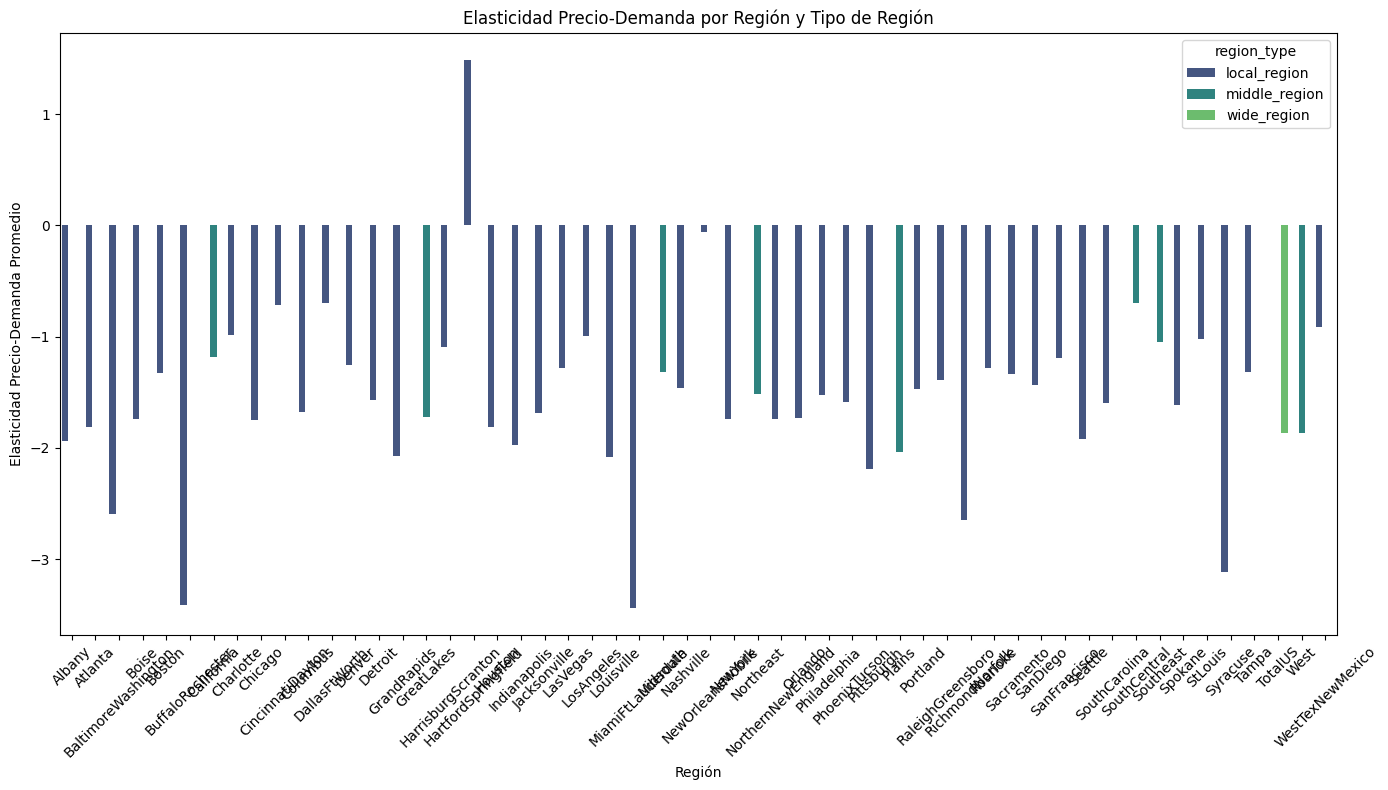

In [10]:
# Calcular la variación porcentual para Total Volume y AveragePrice por región
avocado['Volume Change (%)'] = avocado.groupby(['region'])['Total Volume'].pct_change()
avocado['Price Change (%)'] = avocado.groupby(['region'])['AveragePrice'].pct_change()

# Calcular la elasticidad del precio de la demanda
avocado['Elasticity'] = avocado['Volume Change (%)'] / avocado['Price Change (%)']

# Limpiar los datos (eliminar valores infinitos e inexistentes)
avocado['Elasticity'].replace([float('inf'), float('-inf')], pd.NA, inplace=True)
avocado.dropna(subset=['Elasticity'], inplace=True)

# Agrupar por región y tipo de región, y calcular la elasticidad promedio
elasticity_by_region_type = avocado.groupby(['region', 'region_type'])['Elasticity'].mean().reset_index()

# Visualización: Gráfico de barras con elasticidad por región y tipo de región
plt.figure(figsize=(14, 8))
sns.barplot(data=elasticity_by_region_type, x='region', y='Elasticity', hue='region_type', palette='viridis', dodge=True)
plt.title('Elasticidad Precio-Demanda por Región y Tipo de Región')
plt.xlabel('Región')
plt.ylabel('Elasticidad Precio-Demanda Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

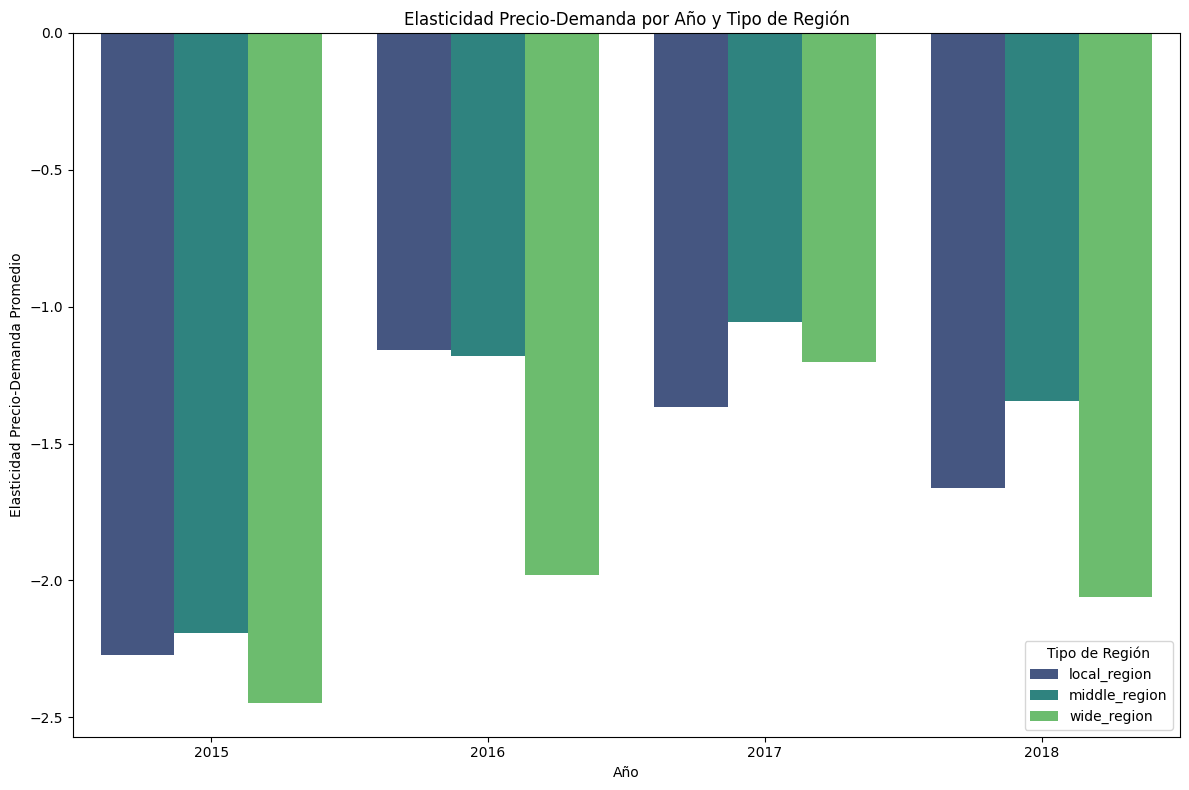

In [11]:
# Calcular la variación porcentual para Total Volume y AveragePrice por región
avocado['Volume Change (%)'] = avocado.groupby(['region'])['Total Volume'].pct_change()
avocado['Price Change (%)'] = avocado.groupby(['region'])['AveragePrice'].pct_change()

# Calcular la elasticidad del precio de la demanda
avocado['Elasticity'] = avocado['Volume Change (%)'] / avocado['Price Change (%)']

# Limpiar los datos (eliminar valores infinitos e inexistentes)
avocado['Elasticity'].replace([float('inf'), float('-inf')], pd.NA, inplace=True)
avocado.dropna(subset=['Elasticity'], inplace=True)

# Agrupar por tipo de región y año, y calcular la elasticidad promedio
elasticity_by_region_type_year = avocado.groupby(['region_type', 'year'])['Elasticity'].mean().reset_index()

# Visualización: Gráfico de barras con elasticidad por tipo de región y año
plt.figure(figsize=(12, 8))
sns.barplot(data=elasticity_by_region_type_year, x='year', y='Elasticity', hue='region_type', palette='viridis', dodge=True)
plt.title('Elasticidad Precio-Demanda por Año y Tipo de Región')
plt.xlabel('Año')
plt.ylabel('Elasticidad Precio-Demanda Promedio')
plt.legend(title='Tipo de Región')
plt.tight_layout()
plt.show()

3. **Elasticidad a Nivel de Tipo de Bolsa:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Bags`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda específica para cada tipo de bolsa.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `groupby()` y `sum()`.
     - Calcula la elasticidad para cada tipo y presenta los resultados en un gráfico comparativo usando `plt.bar()`.

4. **Análisis de Elasticidad Comparativa entre Orgánicos y Convencionales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `type`.
   - **Esperado:** Compara la elasticidad de la demanda entre aguacates orgánicos y convencionales.
     - Agrupa los datos por `type` y calcula la elasticidad utilizando `pd.pct_change()`.
     - Presenta un gráfico que muestre la diferencia en elasticidad entre los dos tipos usando `plt.bar()`.

C:\Users\HP\AppData\Local\Temp\ipykernel_21152\1597431921.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=elasticity_by_type, x='type', y='Elasticity', palette='Set2')


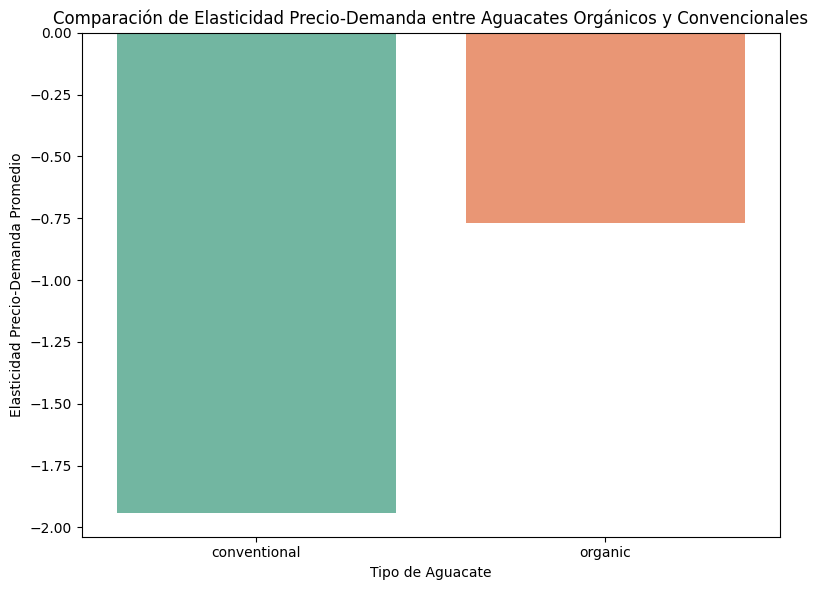

In [12]:
#codigo
avocado['Volume Change (%)'] = avocado.groupby('type')['Total Volume'].pct_change()
avocado['Price Change (%)'] = avocado.groupby('type')['AveragePrice'].pct_change()

# Calcular la elasticidad del precio de la demanda
avocado['Elasticity'] = avocado['Volume Change (%)'] / avocado['Price Change (%)']

# Limpiar datos eliminando valores infinitos y NaN
avocado['Elasticity'].replace([float('inf'), float('-inf')], pd.NA, inplace=True)
avocado.dropna(subset=['Elasticity'], inplace=True)

# Agrupar por `type` y calcular la elasticidad promedio
elasticity_by_type = avocado.groupby('type')['Elasticity'].mean().reset_index()

# Visualización: Gráfico de barras con elasticidad por tipo de aguacate
plt.figure(figsize=(8, 6))
sns.barplot(data=elasticity_by_type, x='type', y='Elasticity', palette='Set2')
plt.title('Comparación de Elasticidad Precio-Demanda entre Aguacates Orgánicos y Convencionales')
plt.xlabel('Tipo de Aguacate')
plt.ylabel('Elasticidad Precio-Demanda Promedio')
plt.tight_layout()
plt.show()

5. **Análisis de la Elasticidad Precios-Ventas:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Examina cómo las variaciones en `AveragePrice` afectan a `Total Volume`.
     - Realiza un análisis de la relación entre estas dos variables calculando la elasticidad.
     - Presenta un gráfico de dispersión que muestre la relación y discute la tendencia observada utilizando `plt.scatter()` y `plt.plot()`.

### 4. **Análisis de Cohortes**
**Resumen:** El análisis de cohortes permite agrupar datos según características específicas y observar cómo se comportan a lo largo del tiempo. Se centra en cohortes de precios y ventas para entender las dinámicas del mercado.

1. **Cohortes Basadas en Precios Promedios Trimestrales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `Date`.
   - **Esperado:** Crea cohortes trimestrales y analiza cambios en precios y volúmenes.
     - Agrupa los datos por trimestre usando `pd.Grouper` con `freq='Q'`.
     - Calcula el promedio de `AveragePrice` y suma `Total Volume` para cada cohorte.
     - Visualiza los resultados en un gráfico de líneas que muestre la evolución de las cohortes.

2. **Cohortes por Región y Fecha:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice`, `Total Volume`, `region` y `Date`.
   - **Esperado:** Analiza cómo varían las cohortes de diferentes regiones.
     - Agrupa los datos por `region` y `Date` usando `groupby()`.
     - Calcula el promedio de precios y volumen para cada cohorte.
     - Presenta los resultados en gráficos de barras que muestren comparaciones entre regiones.

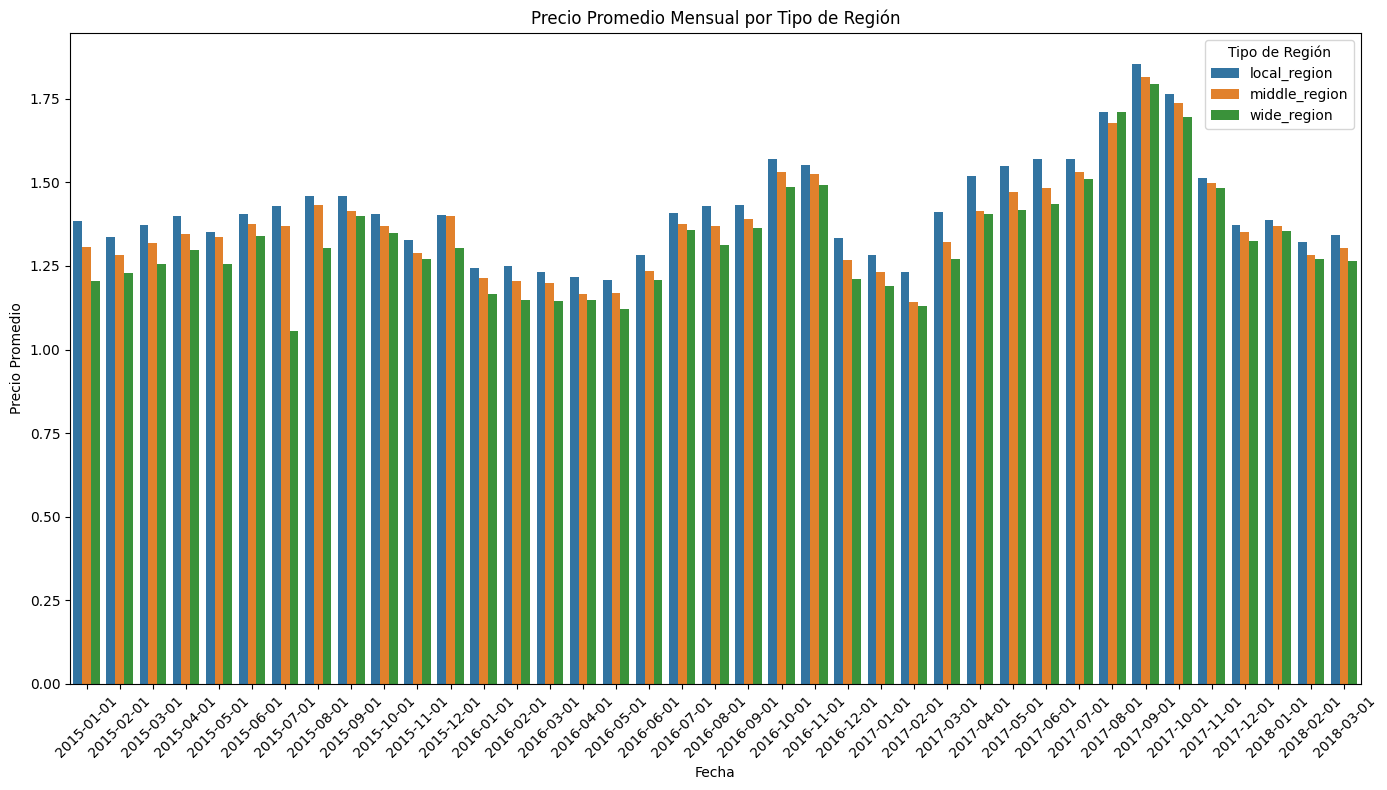

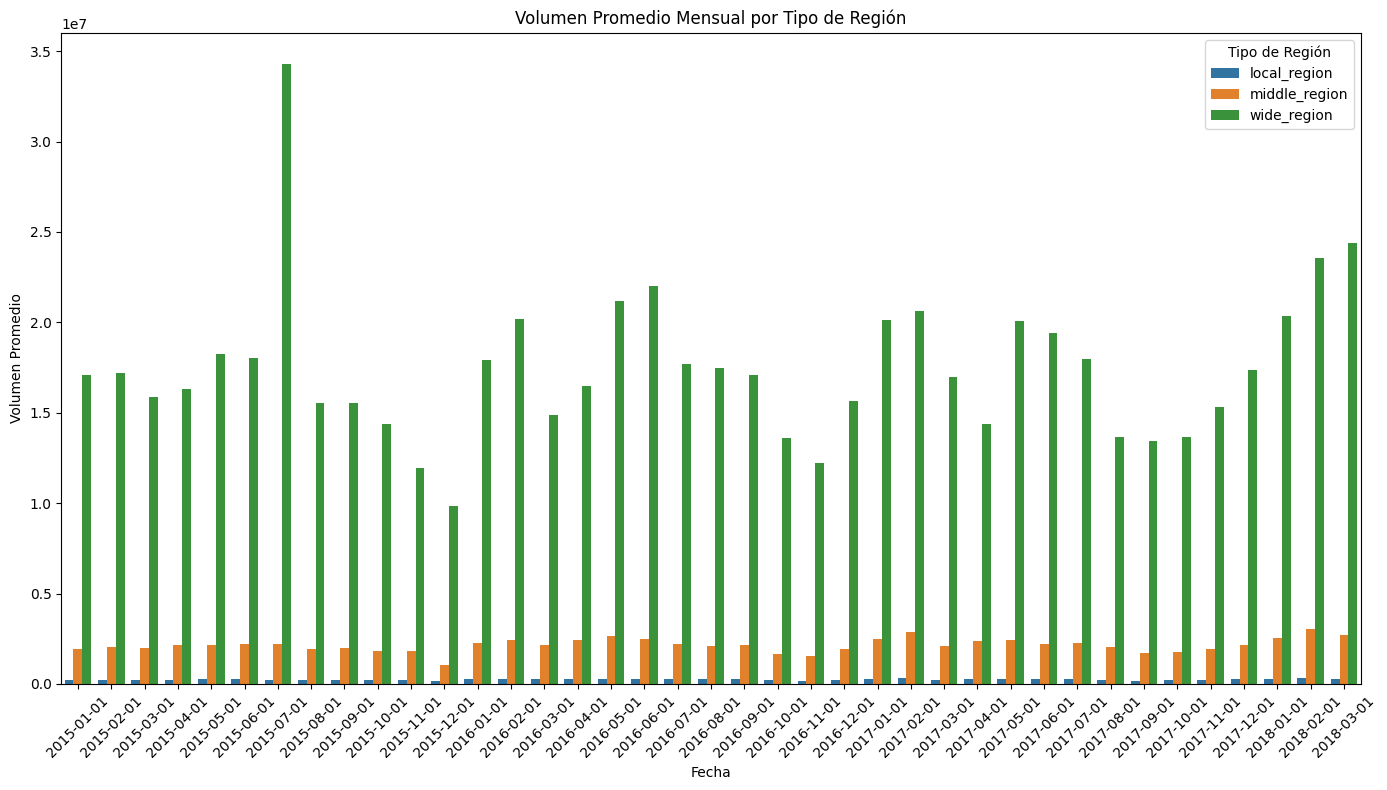

In [13]:
# Agrupación mensual por tipo de región
cohort_data_monthly = avocado.groupby(['region_type', avocado['Date'].dt.to_period("M")]).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'mean'
}).reset_index()
cohort_data_monthly['Date'] = cohort_data_monthly['Date'].dt.to_timestamp()  # Convertir periodo a timestamp

# Gráfico de barras agrupado para precios promedio mensual por tipo de región
plt.figure(figsize=(14, 8))
sns.barplot(data=cohort_data_monthly, x='Date', y='AveragePrice', hue='region_type')
plt.title('Precio Promedio Mensual por Tipo de Región')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Región')
plt.tight_layout()
plt.show()

# Gráfico de barras agrupado para volumen promedio mensual por tipo de región
plt.figure(figsize=(14, 8))
sns.barplot(data=cohort_data_monthly, x='Date', y='Total Volume', hue='region_type')
plt.title('Volumen Promedio Mensual por Tipo de Región')
plt.xlabel('Fecha')
plt.ylabel('Volumen Promedio')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Región')
plt.tight_layout()
plt.show()

3. **Análisis de Cohortes en Función del Tipo de Bolsa:**
   - **Uso de Datos:** Usa las columnas `Total Bags`, `Small Bags`, `Large Bags`, `XLarge Bags` y `Date`.
   - **Esperado:** Examina cómo se comportan las diferentes cohortes según el tipo de bolsa.
     - Agrupa los datos por tipo de bolsa y `Date`.
     - Calcula el volumen de ventas total y muestra los resultados en un gráfico de líneas.

4. **Cohortes de Clientes Basadas en Ventas:**
   - **Uso de Datos:** Usa las columnas `Total Volume`, `Date` y `region`.
   - **Esperado:** Analiza el comportamiento de las cohortes según el volumen de ventas.
     - Clasifica los clientes según su volumen de compras.
     - Visualiza las cohortes en gráficos de líneas o barras que muestren el comportamiento de compra a lo largo del tiempo.

C:\Users\HP\AppData\Local\Temp\ipykernel_21152\644256972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


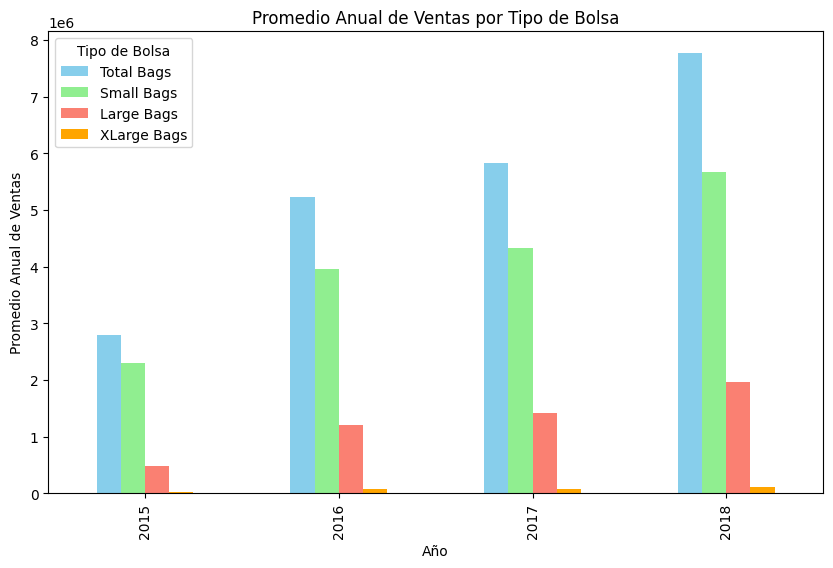

In [14]:
#codigo
def sales_yearly_average_bag(df):
    # Convertir la columna 'Date' a formato datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Agrupar por año y calcular el promedio de ventas anuales para cada tipo de bolsa
    yearly_avg = df.groupby(df['Date'].dt.year)[['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']].mean()

    # Crear gráfico de barras de los promedios anuales para cada tipo de bolsa
    plt.figure(figsize=(10, 6))
    yearly_avg.plot(kind='bar', stacked=False, color=['skyblue', 'lightgreen', 'salmon', 'orange'], ax=plt.gca())
    
    # Configuración del gráfico
    plt.title('Promedio Anual de Ventas por Tipo de Bolsa')
    plt.xlabel('Año')
    plt.ylabel('Promedio Anual de Ventas')
    plt.legend(title="Tipo de Bolsa")
    
    plt.show()

# Llamada a la función con el DataFrame adecuado
sales_yearly_average_bag(avo_wide)

5. **Evaluación de Retención de Ventas por Cohorte:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `Date`.
   - **Esperado:** Estudia cómo se retienen las ventas en cohortes a lo largo de un año.
     - Agrupa los datos por mes y cohortes.
     - Calcula la retención de ventas y visualiza los resultados en un gráfico de líneas que muestre las tasas de retención.

### 5. **Análisis de Correlación y Regresión**
**Resumen:** Se centra en la identificación de relaciones significativas entre las variables numéricas y el desarrollo de modelos de regresión para hacer predicciones basadas en esas relaciones.

1. **Matriz de Correlación:** 
   - **Uso de Datos:** Utiliza las columnas numéricas del DataFrame (p. ej., `AveragePrice`, `Total Volume`, `4046`, `4225`, `4770`, `Total Bags`).
   - **Esperado:** 
     - Importa las librerías necesarias: `import seaborn as sns` y `import matplotlib.pyplot as plt`.
     - Calcula la matriz de correlación usando el método `.corr()` del DataFrame.
     - Visualiza la matriz utilizando `sns.heatmap()`. 
     - Anota las correlaciones más significativas y discute su posible impacto en el análisis.

2. **Análisis de Dispersión entre Variables Clave:** 
   - **Uso de Datos:** Selecciona variables numéricas de interés como `AveragePrice` y `Total Volume`.
   - **Esperado:** 
     - Importa las librerías necesarias: `import seaborn as sns` y `import matplotlib.pyplot as plt`.
     - Crea un gráfico de dispersión con `sns.scatterplot()` para visualizar la relación entre `AveragePrice` y `Total Volume`.
     - Añade una línea de regresión utilizando `sns.regplot()` para ilustrar las tendencias.
     - Compara el ajuste de una regresión lineal frente a una polinómica.

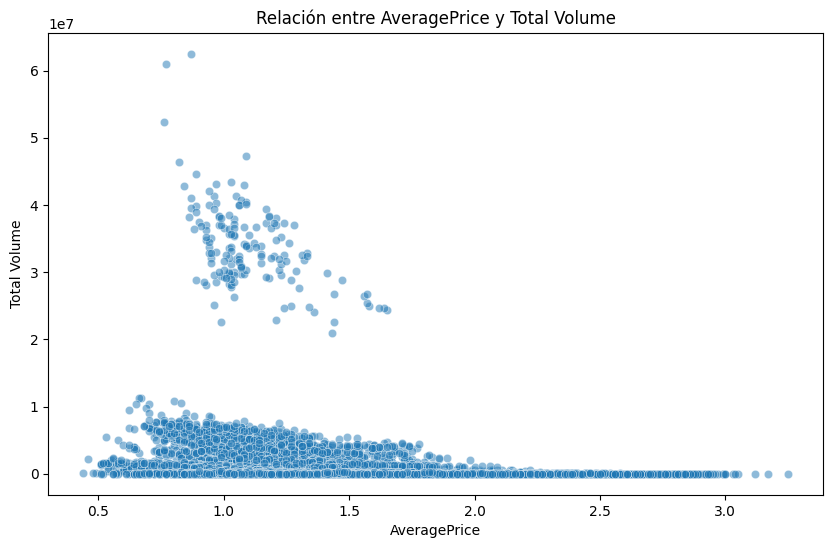

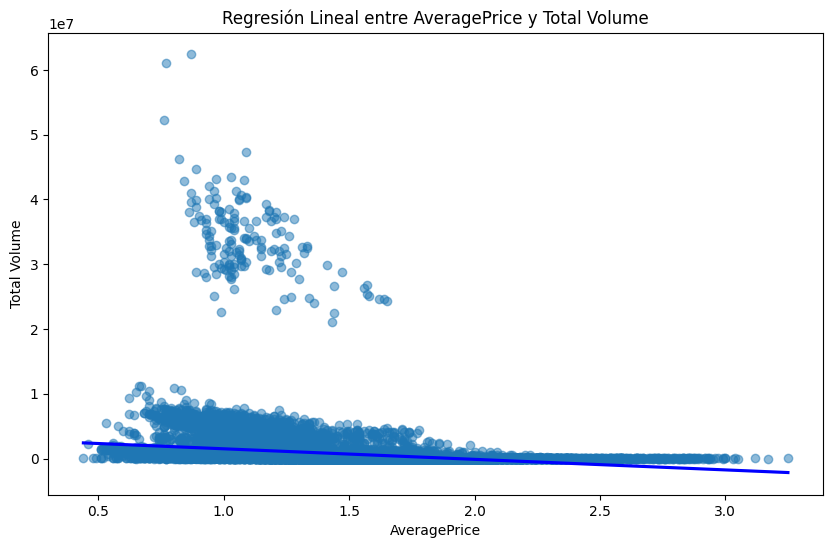

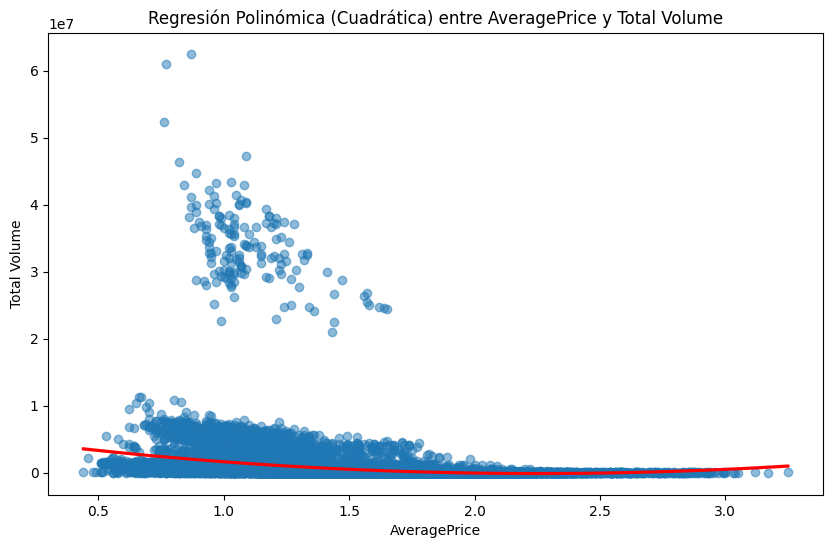

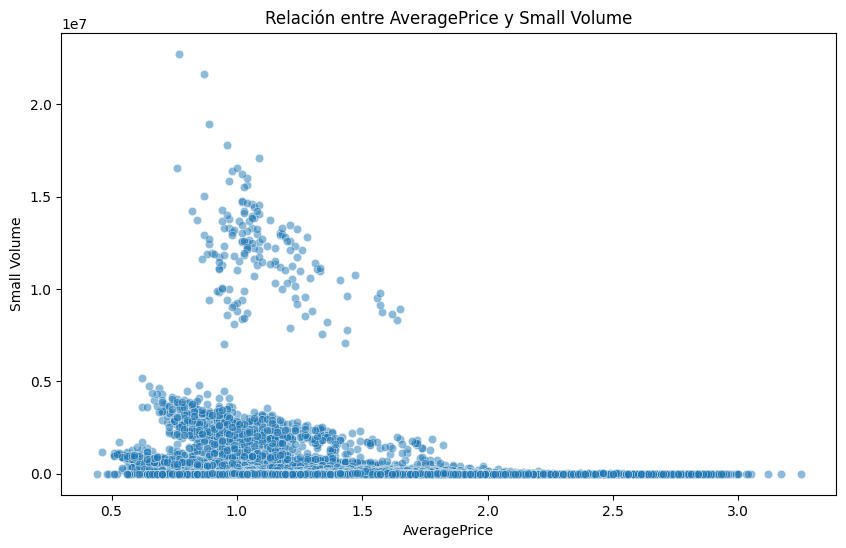

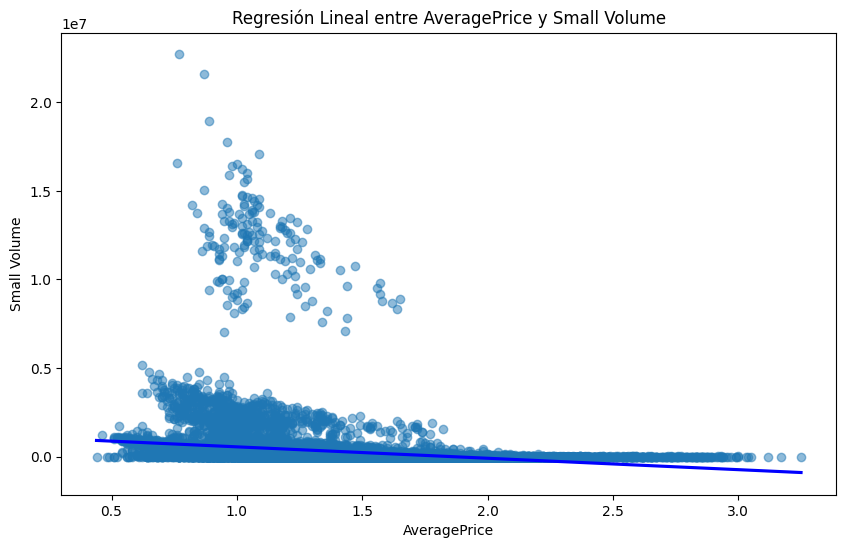

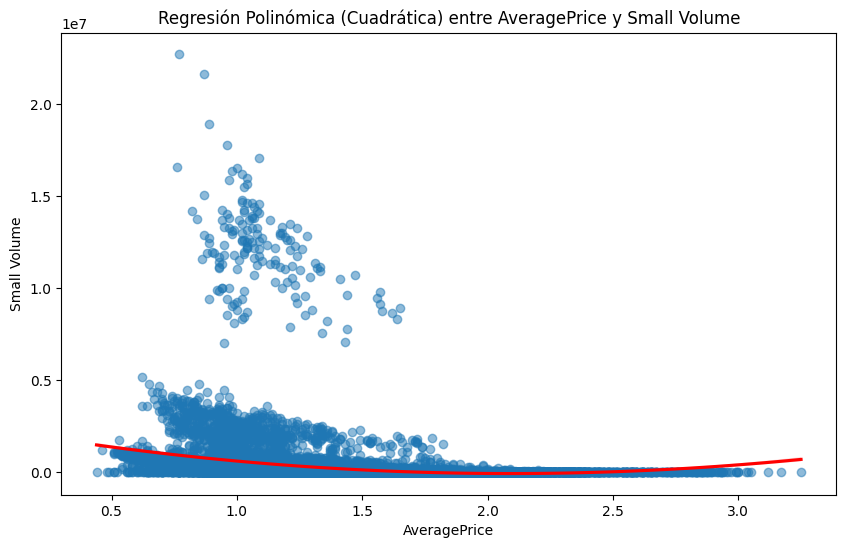

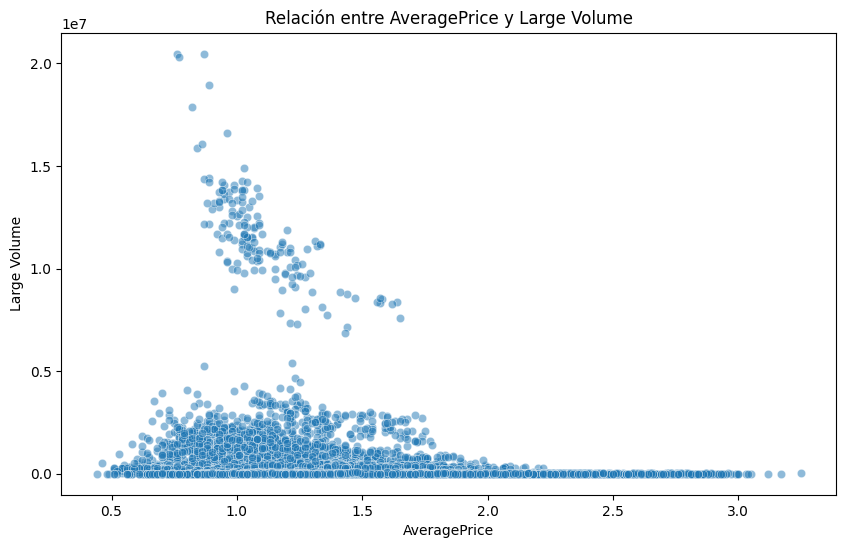

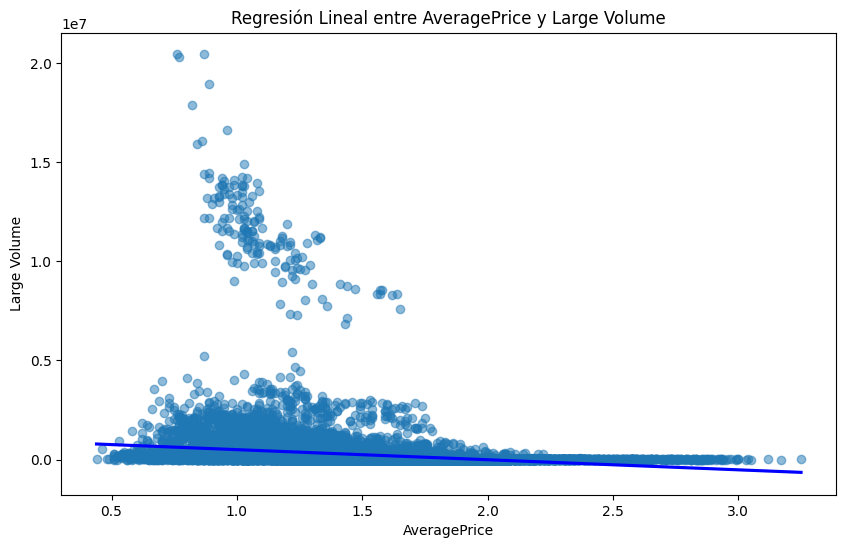

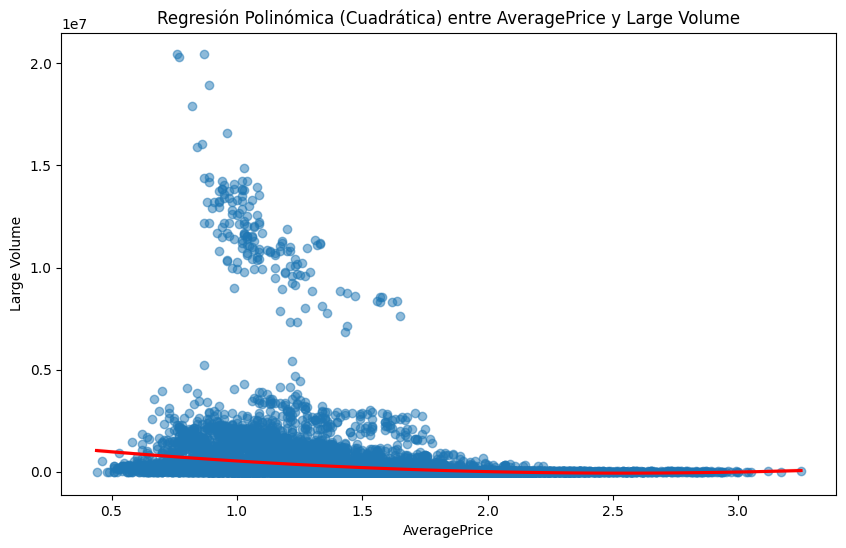

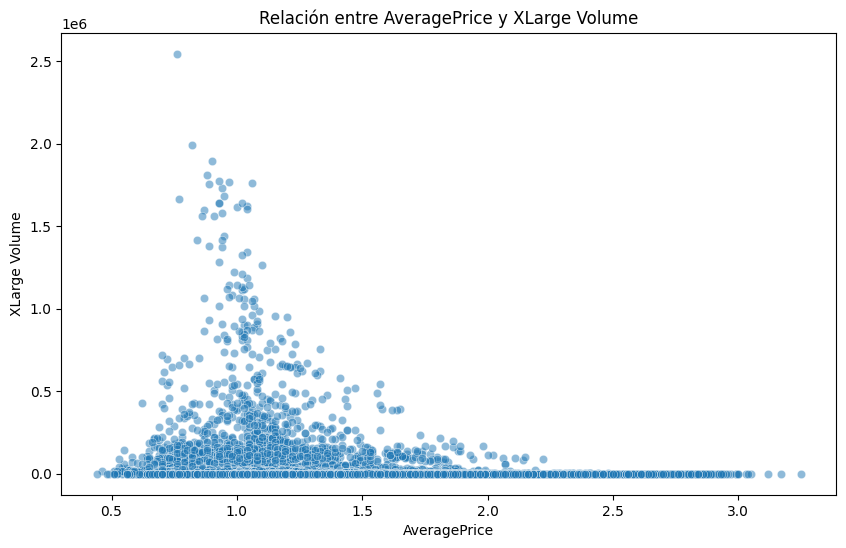

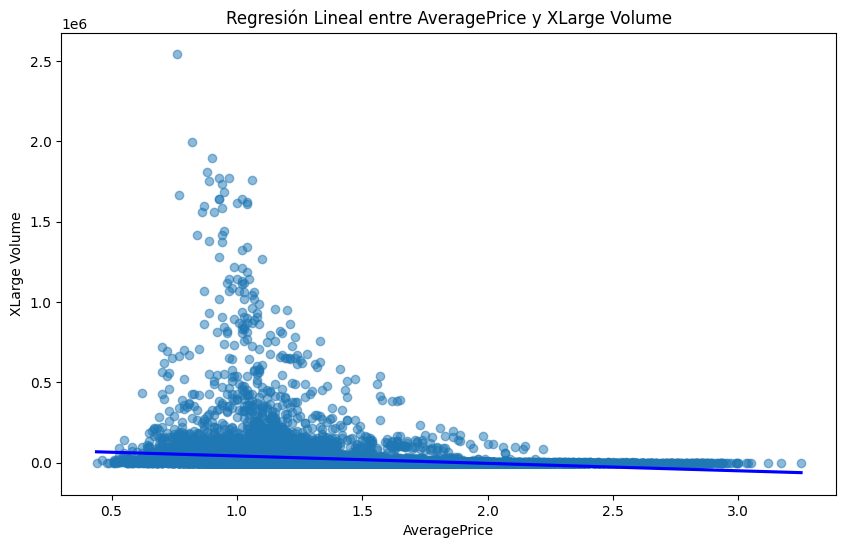

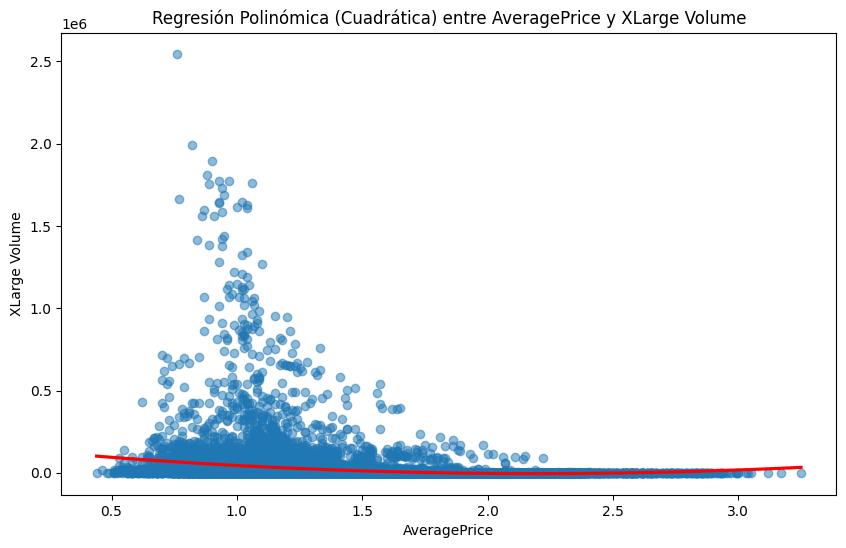

In [15]:
#codigo
#codigo
# Listado de combinaciones de variables para analizar
combinations = [
    ('AveragePrice', 'Total Volume'),
    ('AveragePrice', 'Small Volume'),
    ('AveragePrice', 'Large Volume'),
    ('AveragePrice', 'XLarge Volume')
]

# Iteración a través de las combinaciones para crear gráficos
for x_var, y_var in combinations:
    # Gráfico de dispersión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=avocado, x=x_var, y=y_var, alpha=0.5)
    plt.title(f'Relación entre {x_var} y {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()
    
    # Regresión lineal
    plt.figure(figsize=(10, 6))
    sns.regplot(data=avocado, x=x_var, y=y_var, scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'})
    plt.title(f'Regresión Lineal entre {x_var} y {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()
    
    # Regresión polinómica (cuadrática)
    plt.figure(figsize=(10, 6))
    sns.regplot(data=avocado, x=x_var, y=y_var, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}, order=2)
    plt.title(f'Regresión Polinómica (Cuadrática) entre {x_var} y {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()